In [1]:
# import des librairies

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from collections import Counter



    
# Partie 1:  Procéder au rapprochement des données issues de l'extraction ERP (erp.xlsx) avec celles issues de notre site marchand (web.xlsx)  

<b> Le rapprochement est effectué grâce au référentiel id_product / sku crée par Sylvie (dans le fichier "liaison.xlsx")

In [2]:
# ignore le message d'erreur openpyxl qui s'affiche lors de la lecture des fichiers .xlsx 
# mais qui n'empêche cependant pas leur chargement
warnings.filterwarnings('ignore', category=UserWarning, module='openpyxl')

# import des 3 fichiers excel : erp.xlsx, web.xlsx et liaison.xlsx
data_erp = pd.read_excel('erp.xlsx')
data_web = pd.read_excel('web.xlsx')
data_liaison = pd.read_excel('liaison.xlsx')



<b> Analyse des fichiers :
Comme il s'agit des même vérification pour les différents fichiers, on créé les fonctions 'description' et 'doublon' pour alléger le code.

In [3]:
def description(fichier):

    ## affiche le nombre de lignes et de variables dans le dataframe
    print("data shape :", fichier.shape,'\n')
      
    ## liste les variables et indique le type de valeurs qu'elles contiennent
    print(fichier.dtypes, '\n')
    
    ## décrit le contenu des variables et indique le nombre de valeurs,les quartiles, min, max, moy, median
    print(fichier.describe(), '\n')
    
    ## calcul le nombre de nan pour chaque variable et affiche celles qui en ont au moins 1
    nb_na = fichier.isnull().sum()
    print("vérification nan :",'\n',nb_na[nb_na>0])

    
def doublon(fichier,variable):
    ## affiche les lignes dont les valeurs de la variable selectionnée ont au moins 1 doublon
    df_doublon = fichier.loc[fichier[variable].duplicated(keep=False)]
    df_doublon

In [4]:
# Analyse du fichier erp
description(data_erp)

data shape : (825, 5) 

product_id          int64
onsale_web          int64
price             float64
stock_quantity      int64
stock_status       object
dtype: object 

        product_id  onsale_web       price  stock_quantity
count   825.000000  825.000000  825.000000      825.000000
mean   5162.597576    0.869091   32.415636       26.496970
std     902.644635    0.337506   26.795849       45.892422
min    3847.000000    0.000000    5.200000        0.000000
25%    4348.000000    1.000000   14.600000        1.000000
50%    4907.000000    1.000000   24.400000       11.000000
75%    5805.000000    1.000000   42.000000       34.000000
max    7338.000000    1.000000  225.000000      578.000000 

vérification nan : 
 Series([], dtype: int64)


<b> On remarque un écart important entre la valeur max et moyenne/std pour la variable "price" pour lesquelles il serait judicieux de procéder à des vérifications une fois les premières vérifications effectuées. 

In [5]:
# analyse du fichier data_liaison
description(data_liaison)

data shape : (825, 2) 

product_id     int64
id_web        object
dtype: object 

        product_id
count   825.000000
mean   5162.597576
std     902.644635
min    3847.000000
25%    4348.000000
50%    4907.000000
75%    5805.000000
max    7338.000000 

vérification nan : 
 id_web    91
dtype: int64


<b> Remarque : 91 lignes dans le df liaision ont des valeurs nulles dans id_web. 
Cette variable sera notre clé pour procéder au merge de nos différentes sources (et ne peuvent donc pas être nulles). 
Il faudra créer un nouveau df filtré pour les exclure de nos manipulations.  

In [6]:
# création du df filtered_data_liaison avec seulement les lignes dont la valeur id_web est non-nulle
filtered_data_liaison = data_liaison.loc[data_liaison['id_web'].notnull(),:]

# description du nouveau df pour vérifier la bonne application du filtre
description(filtered_data_liaison)

data shape : (734, 2) 

product_id     int64
id_web        object
dtype: object 

        product_id
count   734.000000
mean   5041.859673
std     790.309295
min    3847.000000
25%    4287.250000
50%    4862.500000
75%    5714.250000
max    7338.000000 

vérification nan : 
 Series([], dtype: int64)


In [7]:
# analyse du fichier data_web
description(data_web)

data shape : (1513, 28) 

sku                              object
virtual                           int64
downloadable                      int64
rating_count                      int64
average_rating                  float64
total_sales                     float64
tax_status                       object
tax_class                       float64
post_author                     float64
post_date                datetime64[ns]
post_date_gmt            datetime64[ns]
post_content                    float64
post_title                       object
post_excerpt                     object
post_status                      object
comment_status                   object
ping_status                      object
post_password                   float64
post_name                        object
post_modified            datetime64[ns]
post_modified_gmt        datetime64[ns]
post_content_filtered           float64
post_parent                     float64
guid                             object
menu_order    

<b> Le fichier web contient 1513 lignes vs 825 dans le fichier erp, or, un produit web est obligatoirement présent dans le logiciel erp (vu qu'il s'agit du logiciel qui sert notamment à la gestion des stocks), on déduit donc qu'il contient des doublons.

<b> On remarque aussi des valeurs nulles en variable sku (2), qui vont poser problème lors du merge des différents fichiers.

In [8]:
# afficher le nombre de doublons
print("Il y a", data_web.duplicated('sku').sum(), "doublons")

Il y a 798 doublons


In [9]:
# affiche les lignes correspondant à un des sku pris aléatoirement dans la liste
check_data_web = data_web.loc[data_web['sku'] == 15298,:]
check_data_web

,sku,virtual,downloadable,rating_count,average_rating,total_sales,tax_status,tax_class,post_author,post_date,...,post_name,post_modified,post_modified_gmt,post_content_filtered,post_parent,guid,menu_order,post_type,post_mime_type,comment_count
1,15298,0,0,0,0.0,6.0,taxable,NaN,2.0,2018-02-08 12:58:52,...,pierre-jean-villa-saint-joseph-preface-2018,2019-12-30 09:30:29,2019-12-30 08:30:29,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
799,15298,0,0,0,0.0,6.0,NaN,NaN,2.0,2018-02-08 12:58:52,...,pierre-jean-villa-saint-joseph-preface-2018,2019-12-30 09:30:29,2019-12-30 08:30:29,NaN,0.0,https://www.bottle-neck.fr/wp-content/uploads/...,0.0,attachment,image/jpeg,0.0


<b> Les doublons semblent s'expliquer dans la variable "post_type" : il existe une entrée "product" correspondant à la fiche produit sur le site  et une entrée "attachment" qui correspond à l'image qui a été attachée à la fiche. 

<b> Cela pose problème car les ventes d'un même produit sont rattachées sur les 2 lignes et peut entrainer un double compte de chiffre d'affaires. Nous allons filtrer sur "product" (car un produit a forcément une fiche mais pas obligatoirement d'image).

<b> Avant cela, il semble nécéssaire de pousser plus loin l'analyse de la variable 'post_type' pour voir si d'autres valeurs existent.

In [10]:
# liste les valeurs uniques existant pour la variable 'post_type'
unique_post_type_web = set(data_web['post_type'])
unique_post_type_web

{'attachment', nan, 'product'}

<b> Des valeurs 'nan' existent pour certaines lignes dans la variable 'post_type'

In [11]:
# affiche les lignes pour lesquelles la valeur de 'post_type' est nulle (nan)
check_data_web = data_web.loc[data_web['post_type'].isnull(),:]
check_data_web


,sku,virtual,downloadable,rating_count,average_rating,total_sales,tax_status,tax_class,post_author,post_date,...,post_name,post_modified,post_modified_gmt,post_content_filtered,post_parent,guid,menu_order,post_type,post_mime_type,comment_count
178,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaT,...,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
179,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaT,...,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
227,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaT,...,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
230,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaT,...,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
231,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaT,...,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
792,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaT,...,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
793,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaT,...,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
794,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaT,...,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
795,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaT,...,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<b> Après vérification, 83 lignes du fichier sont entièrement vides et peuvent être supprimées.

In [12]:
# supprime les lignes entièrement vides de data_web
data_web.drop(data_web.loc[data_web['post_type'].isnull()].index, inplace=True)
check_data_web = data_web.loc[data_web['post_type'].isnull(),:]
# affiche un aperçu du nombre de ligne
print("data shape :",data_web.shape)

data shape : (1430, 28)


<b> On peut désormais filtrer les données sur les valeurs 'product' de la variable 'post_type'.

In [13]:
filtered_data_web = data_web.loc[data_web['post_type'] == 'product',:]
filtered_data_web.head()

,sku,virtual,downloadable,rating_count,average_rating,total_sales,tax_status,tax_class,post_author,post_date,...,post_name,post_modified,post_modified_gmt,post_content_filtered,post_parent,guid,menu_order,post_type,post_mime_type,comment_count
0,bon-cadeau-25-euros,0,0,0,0.0,10.0,taxable,NaN,1.0,2018-06-01 13:53:46,...,bon-cadeau-de-25-euros,2018-06-01 14:13:57,2018-06-01 12:13:57,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
1,15298,0,0,0,0.0,6.0,taxable,NaN,2.0,2018-02-08 12:58:52,...,pierre-jean-villa-saint-joseph-preface-2018,2019-12-30 09:30:29,2019-12-30 08:30:29,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
2,15296,0,0,0,0.0,0.0,taxable,NaN,2.0,2018-02-08 13:49:41,...,pierre-jean-villa-saint-joseph-tilde-2017,2019-12-21 09:00:17,2019-12-21 08:00:17,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
3,15300,0,0,0,0.0,0.0,taxable,NaN,2.0,2018-02-08 14:08:36,...,pierre-jean-villa-croze-hermitage-accroche-coe...,2020-06-26 18:15:03,2020-06-26 16:15:03,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
4,19814,0,0,0,0.0,3.0,taxable,NaN,2.0,2018-02-09 14:01:05,...,pierre-jean-villa-igp-gamine-2018,2020-01-04 16:36:01,2020-01-04 15:36:01,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0


<b> Il  nous reste à traiter les lignes repérées plus tôt pour lesquelles les valeurs 'sku' sont nulles, nous allons les filtrer car non identifiables et non chainables avec le fichier erp.
    
<b> Remarque : le 1er produit de la liste correspond à un bon cadeau, il faudra vérifier s'il existe d'autres produits de ce type dans la liste afin de l"isoler à l'étape du calcul du CA total (et eviter de double compter ces valeurs)

In [14]:
# filtrage excluant les 2 lignes pour lesquelles les valeurs sku sont nulles 

filtered_data_web = filtered_data_web.loc[filtered_data_web['sku'].notnull(), :]
description(filtered_data_web)

data shape : (714, 28) 

sku                              object
virtual                           int64
downloadable                      int64
rating_count                      int64
average_rating                  float64
total_sales                     float64
tax_status                       object
tax_class                       float64
post_author                     float64
post_date                datetime64[ns]
post_date_gmt            datetime64[ns]
post_content                    float64
post_title                       object
post_excerpt                     object
post_status                      object
comment_status                   object
ping_status                      object
post_password                   float64
post_name                        object
post_modified            datetime64[ns]
post_modified_gmt        datetime64[ns]
post_content_filtered           float64
post_parent                     float64
guid                             object
menu_order     

<b> Avant de procéder au rapprochement des fichiers, on va tout d'abord contrôler la pertinence du fichier liaison qui est notre clé pour procéder à la jointure.

<b> On va dans un premier temps creer une fonction pour vérifier que tous les produits de l'ERP sont bien présents et que tous les produits web ont bien étés chaînés.

<b> On renomme enfin la variable "id_web" en "sku" afin que nous ayons le même naming dans les df liaison et web

In [15]:
# création d'un fonction permettant de lister les valeurs uniques d'une variable pour 2 fichiers différents
# de les comparer entre elles et voir si elles sont identiques, si les valeurs de la 1ère liste sont contenues dans la seconde
# ou compter le nombre de valeurs manquantes de la 1ere liste dans la seconde le cas échéant

def comparaison_listes(donnees_source, donnees_liaison, variable_source, variable_liaison):
    ## crée un listing des valeurs uniques d'une variable choisie du fichier source
    liste_unique_source = set(donnees_source[variable_source]) 
    ## crée un listing des valeurs uniques d'une variable choisie du fichier de liaison
    liste_unique_liaison = set(donnees_liaison[variable_liaison]) # créer 

    ## si les listes sont identiques, affiche un texte spécifique
    if(liste_unique_source == liste_unique_liaison):
        print("les listes sont identiques")
    
    ## sinon, vérifie que les valeurs uniques de la liste sources sont toutes contenues dans la liste liaison et l'affiche
    elif(len(liste_unique_source & liste_unique_liaison)==len(liste_unique_source)):
        print("tous les identifiants du fichier source sont présents dans le fichier liaison")
    
    ## sinon, affiche le nombre de valeurs manquantes
    else: 
        print("Nombre d'identifiants absents du fichier liaison:", len(liste_unique_source)-len(liste_unique_source & liste_unique_liaison))

In [16]:
# procède à la comparaison entre data_erp et filtered_data_liaison sur la base de la variable 'product_id'
comparaison_listes(data_erp ,filtered_data_liaison ,'product_id' ,'product_id')

Nombre d'identifiants absents du fichier liaison: 91


In [17]:
# procède à la comparaison entre filtered_data_web et filtered_data_liaison sur la base des variables 'sku' et 'id_web'
comparaison_listes(filtered_data_web ,filtered_data_liaison ,'sku' ,'id_web')


tous les identifiants du fichier source sont présents dans le fichier liaison


<b> On remarque que 91 product_id sont absents du fichier liaison filtré, il s'agit des 91 lignes que nous avons filtré car il n'existait de correspondance sku.
Quant aux sku, ils sont tous présents dans le fichier liaison en variable id_web (que nous pouvons maintenant renommer pour uniformiser la nomenclature). 



In [18]:
# renomme la colonne id_web en sku pour uniformiser les différents fichiers
filtered_data_liaison = filtered_data_liaison.rename(columns={'id_web' : 'sku'})
filtered_data_liaison


,product_id,sku
0,3847,15298
1,3849,15296
2,3850,15300
3,4032,19814
4,4039,19815
...,...,...
792,7023,15891
793,7025,15887
822,7247,13127-1
823,7329,14680-1


<b> Maintenant que le fichier servant à la liaison a été contrôlé, il est désormais possible de procéder au rapprochement des différents fichiers en un dataframe unique pour faciliter l'analyse.

In [19]:
# sur la base du df data_erp : creé un df_listing_produits et ajout des sku grâce au merge avec le df data_liaison 
df_listing_produits = pd.merge(data_erp,filtered_data_liaison, on='product_id', how='left')
df_listing_produits

,product_id,onsale_web,price,stock_quantity,stock_status,sku
0,3847,1,24.2,0,outofstock,15298
1,3849,1,34.3,0,outofstock,15296
2,3850,1,20.8,0,outofstock,15300
3,4032,1,14.1,0,outofstock,19814
4,4039,1,46.0,0,outofstock,19815
...,...,...,...,...,...,...
820,7203,0,45.0,30,instock,NaN
821,7204,0,45.0,9,instock,NaN
822,7247,1,54.8,23,instock,13127-1
823,7329,0,26.5,14,instock,14680-1


In [20]:
# grâce à la nouvelle variable sku, merge le df_listing_produits avec data_web
df_listing_produits = pd.merge(df_listing_produits,filtered_data_web, on='sku', how='left')

df_listing_produits

,product_id,onsale_web,price,stock_quantity,stock_status,sku,virtual,downloadable,rating_count,average_rating,...,post_name,post_modified,post_modified_gmt,post_content_filtered,post_parent,guid,menu_order,post_type,post_mime_type,comment_count
0,3847,1,24.2,0,outofstock,15298,0.0,0.0,0.0,0.0,...,pierre-jean-villa-saint-joseph-preface-2018,2019-12-30 09:30:29,2019-12-30 08:30:29,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
1,3849,1,34.3,0,outofstock,15296,0.0,0.0,0.0,0.0,...,pierre-jean-villa-saint-joseph-tilde-2017,2019-12-21 09:00:17,2019-12-21 08:00:17,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
2,3850,1,20.8,0,outofstock,15300,0.0,0.0,0.0,0.0,...,pierre-jean-villa-croze-hermitage-accroche-coe...,2020-06-26 18:15:03,2020-06-26 16:15:03,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
3,4032,1,14.1,0,outofstock,19814,0.0,0.0,0.0,0.0,...,pierre-jean-villa-igp-gamine-2018,2020-01-04 16:36:01,2020-01-04 15:36:01,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
4,4039,1,46.0,0,outofstock,19815,0.0,0.0,0.0,0.0,...,pierre-jean-villa-cote-rotie-carmina-2017,2020-01-04 16:36:10,2020-01-04 15:36:10,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
820,7203,0,45.0,30,instock,NaN,NaN,NaN,NaN,NaN,...,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
821,7204,0,45.0,9,instock,NaN,NaN,NaN,NaN,NaN,...,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
822,7247,1,54.8,23,instock,13127-1,0.0,0.0,0.0,0.0,...,clos-du-mont-olivet-chateauneuf-du-pape-2007-2,2020-07-20 17:09:06,2020-07-20 15:09:06,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
823,7329,0,26.5,14,instock,14680-1,NaN,NaN,NaN,NaN,...,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN



# Partie 2: Procéder au calcul du CA par produit et au CA total

<b> Pour cela, nous allons commencer par créer un dataframe contenant seulement les informations nécéssaires au calcul en partant du df_listing_produits précédemment crée. 

<b> Nous allons créer un nouveau df qui conserve seulement les variables 'sku', 'product_id', 'price' et 'total sales' 

<b> Ensuite, nous filtrerons pour conserver seulement les produits qui ont un sku non-nul (car ce sont les seuls produits pour lesquels nous possédons les informations de vente)
    
<b> Après nous allons créer une nouvelle colonne 'turnover' sur la base du calcul suivant : price * total sales  = turnover, ce qui nous permettra d'avoir le CA par produit 
    
<b> Enfin, nous sommer les valeurs de la colonne turnover pour obtenir le CA tous produits (en excluant au préalable les bons d'achat repérés lors des précédents traitements pour ne pas gonfler artificiellement le CA). 

In [21]:
# crée un df appellé df_ventes_prix avec seulement les colonnes pertinentes à l'analyse du CA

    ## crée une liste contenant le nom des colonnes que l'on souhaite conserver
variables_a_conserver = ['product_id','sku','price','total_sales','post_name']
    ## crée le nouveau dataframe en appellant dans le df_listing_produits seulement les colonnes de la liste 
df_ventes_prix = df_listing_produits[variables_a_conserver]

df_ventes_prix

,product_id,sku,price,total_sales,post_name
0,3847,15298,24.2,6.0,pierre-jean-villa-saint-joseph-preface-2018
1,3849,15296,34.3,0.0,pierre-jean-villa-saint-joseph-tilde-2017
2,3850,15300,20.8,0.0,pierre-jean-villa-croze-hermitage-accroche-coe...
3,4032,19814,14.1,3.0,pierre-jean-villa-igp-gamine-2018
4,4039,19815,46.0,0.0,pierre-jean-villa-cote-rotie-carmina-2017
...,...,...,...,...,...
820,7203,NaN,45.0,NaN,NaN
821,7204,NaN,45.0,NaN,NaN
822,7247,13127-1,54.8,0.0,clos-du-mont-olivet-chateauneuf-du-pape-2007-2
823,7329,14680-1,26.5,NaN,NaN


In [22]:
description(df_ventes_prix)

data shape : (825, 5) 

product_id       int64
sku             object
price          float64
total_sales    float64
post_name       object
dtype: object 

        product_id       price  total_sales
count   825.000000  825.000000   714.000000
mean   5162.597576   32.415636     4.012605
std     902.644635   26.795849     8.518183
min    3847.000000    5.200000     0.000000
25%    4348.000000   14.600000     0.000000
50%    4907.000000   24.400000     1.000000
75%    5805.000000   42.000000     4.000000
max    7338.000000  225.000000    96.000000 

vérification nan : 
 sku             91
total_sales    111
post_name      111
dtype: int64


<b> On remarque qu'après filtrage, nous avons 91 lignes pour lesquelles les 'sku' sont manquants, nous allons donc exclure ces lignes car nous n'avons pas d'information 'total_sales' pour celles-ci. 
Il reste cependant 20 lignes pour lesquelles nous n'avons pas de total_sales malgré l'existance d'un sku, il s'agit de lignes pour lesquelles les 'sku' étaient rattachés à un 'product_id' dans le fichier liaison, mais qu'on ne retrouvait pas dans le fichier web (probablement déréférencés du site ?), nous allons donc également exclure ces lignes. 

In [23]:
# conserve seulement les lignes dont la variable 'sku' et 'total_sales' est non-nulle

    ## filtre sur les lignes qui n'ont pas de valeur nulle pour la variable 'sku'
df_ventes_prix= df_ventes_prix.loc[df_ventes_prix['sku'].notnull(),:]

    ## filtre sur les lignes qui n'ont pas de valeur nulle pour la variable 'total_sales'
df_ventes_prix= df_ventes_prix.loc[df_ventes_prix['total_sales'].notnull(),:]


In [24]:
description(df_ventes_prix)

data shape : (714, 5) 

product_id       int64
sku             object
price          float64
total_sales    float64
post_name       object
dtype: object 

        product_id       price  total_sales
count   714.000000  714.000000   714.000000
mean   5032.557423   32.493137     4.012605
std     790.510878   27.810525     8.518183
min    3847.000000    5.200000     0.000000
25%    4280.250000   14.100000     0.000000
50%    4796.000000   23.550000     1.000000
75%    5710.500000   42.175000     4.000000
max    7338.000000  225.000000    96.000000 

vérification nan : 
 Series([], dtype: int64)


In [25]:
# créé la colonne turnover sur la base de la formule turnover = price * total_sales
df_ventes_prix['turnover'] = df_ventes_prix['price'] * df_ventes_prix['total_sales']

df_ventes_prix

,product_id,sku,price,total_sales,post_name,turnover
0,3847,15298,24.2,6.0,pierre-jean-villa-saint-joseph-preface-2018,145.2
1,3849,15296,34.3,0.0,pierre-jean-villa-saint-joseph-tilde-2017,0.0
2,3850,15300,20.8,0.0,pierre-jean-villa-croze-hermitage-accroche-coe...,0.0
3,4032,19814,14.1,3.0,pierre-jean-villa-igp-gamine-2018,42.3
4,4039,19815,46.0,0.0,pierre-jean-villa-cote-rotie-carmina-2017,0.0
...,...,...,...,...,...,...
787,6930,16135,8.4,5.0,mouthes-le-bihan-aime-chai-2015,42.0
792,7023,15891,27.5,0.0,camin-larredya-jurancon-sec-la-virada-2018,0.0
793,7025,15887,69.0,0.0,jamet-cote-rotie-fructus-voluptas-2018,0.0
822,7247,13127-1,54.8,0.0,clos-du-mont-olivet-chateauneuf-du-pape-2007-2,0.0


In [26]:
# affiche le CA tous produits sur la base de la somme des valeurs de la colonne 'turnover' correspondant au CA de chaque pdt

print("Le chiffre d'affaires tous produits s'élève à :", df_ventes_prix['turnover'].sum(), '€')

Le chiffre d'affaires tous produits s'élève à : 70568.6 €


In [27]:
# filtre en excluant la ligne aux sku 'bon-cadeau-25-euros'
df_ventes_prix_hors_bons= df_ventes_prix.loc[df_ventes_prix['sku'] != 'bon-cadeau-25-euros',:]


In [28]:
# affiche le CA tous produits après exclusion des bons d'achat
print("Le chiffre d'affaires tous produits (hors bons d'achat) s'élève à :", df_ventes_prix_hors_bons['turnover'].sum(), '€')

Le chiffre d'affaires tous produits (hors bons d'achat) s'élève à : 70318.6 €



# Partie 3: Analyse des écarts constatés entre le prix max vs moyenne/médiane

C:\Users\ptigr\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='price'>

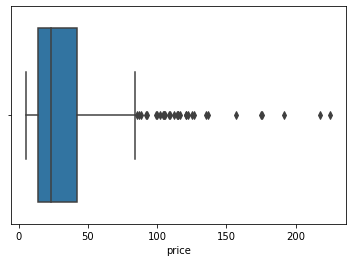

In [29]:
# boxplot sur la base de la variable prix 

sns.boxplot(df_ventes_prix['price'])

In [30]:
# discrétisation afin de visualiser les informations par tranche de prix 

In [31]:
taille_classe = 50 # taille des classes pour la discrétisation

groupes = [] # va recevoir les données agrégées à afficher

# on calcule des tranches allant de 0 au solde maximum par paliers de taille taille_classe
tranches = np.arange(0, max(df_ventes_prix["price"]), taille_classe)
tranches += taille_classe/2 # on décale les tranches d'une demi taille de classe
indices = np.digitize(df_ventes_prix["price"], tranches) # associe chaque prix à son numéro de classe


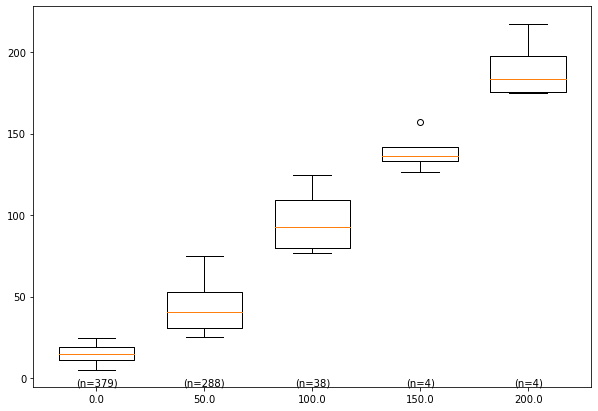

In [32]:
for ind, tr in enumerate(tranches): # pour chaque tranche, ind reçoit le numéro de tranche et tr la tranche en question
    prix = df_ventes_prix.loc[indices==ind,"price"] # sélection des individus de la tranche ind
    if len(prix) > 0:
        g = {
            'valeurs': prix,
            'centre_classe': tr-(taille_classe/2),
            'taille': len(prix),
            'quartiles': [np.percentile(prix,p) for p in [25,50,75]]
        }
        groupes.append(g)

plt.figure(figsize=(10,7))
        
# affichage des boxplots
plt.boxplot([g["valeurs"] for g in groupes],
            positions= [g["centre_classe"] for g in groupes], # abscisses des boxplots
            showfliers= True, # on prend en compte les outliers
            widths= taille_classe*0.7) # largeur graphique des boxplots

# affichage des effectifs de chaque classe
for g in groupes:
    plt.text(g["centre_classe"],0,"(n={})".format(g["taille"]),horizontalalignment='center',verticalalignment='top')     
plt.show()

<b> On remarque qu'il existe 46 produits dont le prix dépasse 75€ 

In [33]:
# affiche la liste des produits au prix > 75€

## filtre sur les valeurs de la variable 'price' >= 75
liste_potentiel_outlier = df_ventes_prix.loc[df_ventes_prix['price'] >= 75,:]
## met l'ensemble des valeurs de la colonne 'price' au format float pour rendre possible le tri
liste_potentiel_outlier['price'] = liste_potentiel_outlier['price'].astype(float)
## trie les lignes de façon décroissante en fonction de la valeur en variable 'price'
liste_potentiel_outlier.sort_values('price', ascending=False)



C:\Users\ptigr\AppData\Local\Temp\ipykernel_15124\1742286113.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  liste_potentiel_outlier['price'] = liste_potentiel_outlier['price'].astype(float)


,product_id,sku,price,total_sales,post_name,turnover
208,4352,15940,225.0,5.0,champagne-egly-ouriet-grand-cru-millesime-2008,1125.0
460,5001,14581,217.5,0.0,david-duband-charmes-chambertin-grand-cru-2014,0.0
635,5892,14983,191.3,3.0,coteaux-champenois-egly-ouriet-ambonnay-rouge-...,573.9
227,4402,3510,176.0,13.0,cognac-frapin-vip-xo,2288.0
598,5767,15185,175.0,0.0,camille-giroud-clos-de-vougeot-2016,0.0
230,4406,7819,157.0,0.0,cognac-frapin-chateau-de-fontpinot-1989-20-ans,0.0
411,4904,14220,137.0,5.0,domaine-des-croix-corton-charlemagne-grand-cru...,685.0
697,6126,14923,135.0,2.0,champagne-gosset-celebris-vintage-2007,270.0
210,4355,12589,126.5,11.0,champagne-egly-ouriet-grand-cru-brut-blanc-de-...,1391.5
556,5612,14915,124.8,0.0,domaine-weinbach-gewurztraminer-gc-furstentum-...,0.0


<b> Il semble difficile de savoir si ces prix sont bel et bien des outliers avec les seules informations dont nous disposons. On remarque cependant que certains des produits aux prix les plus élevés comptabilisent bel et bien des ventes, on peut en déduire qu'il s'agit de produits de gamme premium dont les tarifs sont adaptés. Après analyse des libellés produits, on retrouve des champagnes, des cognacs, des whiskies single cask / single malt et de grands crus de vins qui sont souvent des alcools considérés comme des produits de luxe et ont donc une tarification plus élevée que la moyenne du marché, pouvant s'élever parfois à plus de 100 fois le prix qu'une bouteille classique. 

<b>Exemple: produit le plus cher de la liste et vendu sur un autre site spécialisé : 
sku = 15940 / post_name = champagne-egly-ouriet-grand-cru-millesime-2008	 

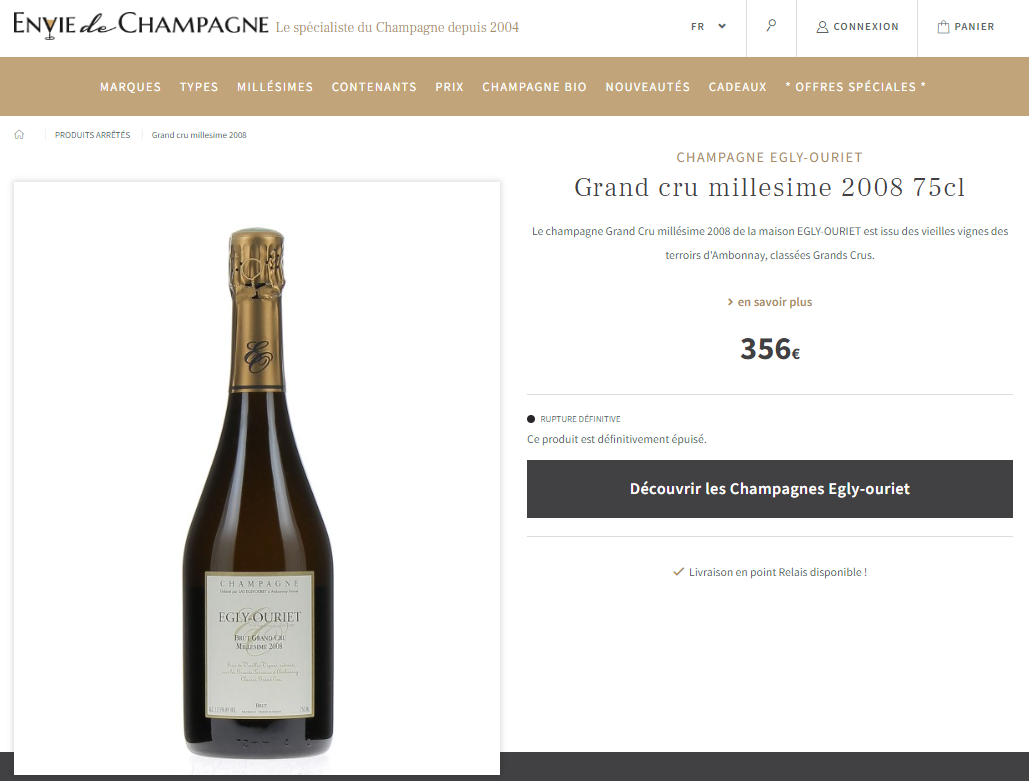

<b> Exemple: des bouteilles au prix >= 2000€ sur le site concurrent
https://www.vinatis.com/

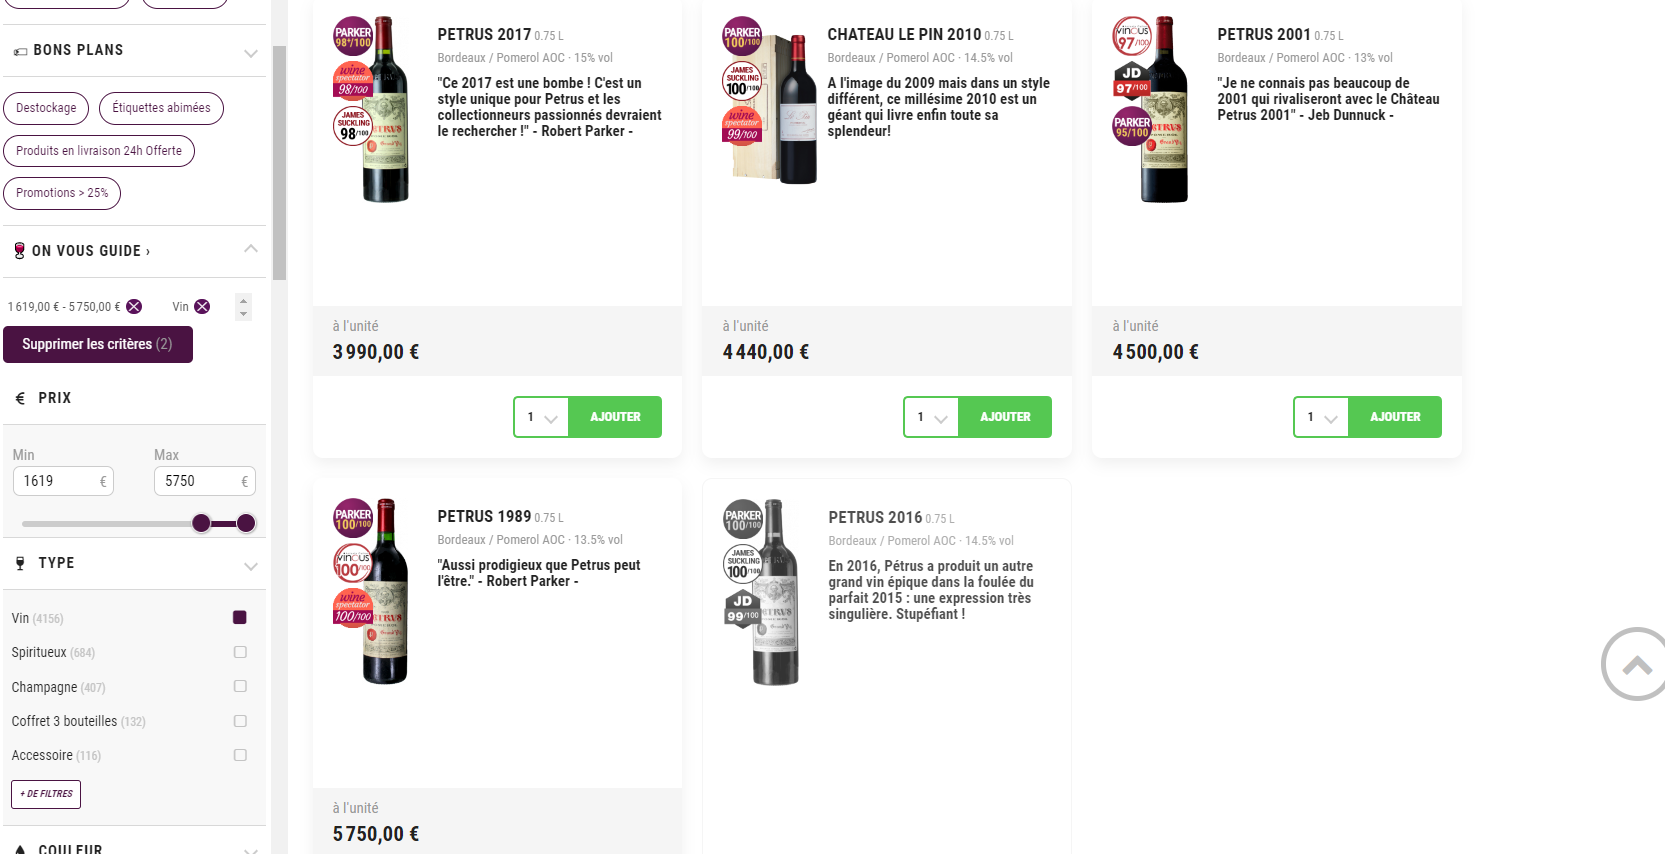